# Audio Spectrogram

#### ECE 4760, Spring 2021, Adams/Land

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import numpy
import matplotlib.pyplot as plt
from IPython.display import Audio
from IPython.display import Image
from scipy import signal
from scipy.fft import fftshift
from scipy.io import wavfile
plt.rcParams['figure.figsize'] = [12, 3]
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Webpage table of contents

> - [Background and Introduction](#Background-and-Introduction)
> - [Mathematical Considerations](#Mathematical-Considerations)
> > - [Nyquist sampling](#Nyquist-sampling)
> > - [The FFT](#The-FFT)
> > - [Hann window](#Hann-window)
> > - [Alpha Max Beta Min Algorithm](#Alpha-Max-Beta-Min-Algorithm)
> - [Hardware](#Hardware)
> > - [Biased high-pass filter](#Biased-high-pass-filter)
> > - [Connection to PIC32](#Connections-to-PIC32)
> - [Program Organization](#Program-organization)
> - [Weekly checkpoints and lab report](#Weekly-checkpoints-and-lab-report)
> > - [Week one checkpoint](#Week-one-required-checkpoint)
> > - [Week two checkpoint](#Week-two-assignment)
> > - [Lab report](#Lab-report)
> - [Example videos](#Examples-of-working-system)

## Background and Introduction

In this lab, we will create a realtime audio [spectrogram](https://en.wikipedia.org/wiki/Spectrogram). A spectrogram provides a visual time-history for the frequency content of a signal. They are extremely interesting in that they provide us with a way to *look at sounds* (and other signals) in a way that our brains can comprehend.

We will use an ADC on the PIC32 to sample an audio signal (your own voice, your favorite song, animal calls, etc.), the PIC32 will compute the FFT for that signal, and the output will be displayed on the TFT. In particular, you will associate each pixel in a row or column of the TFT display to a particular range of frequencies, and you will color the pixels in that row according to the magnitude of the FFT output at those frequencies. By coloring each row/column sequentially, you create a visual time history for the frequencies contained in that audio signal. See the example immediately below, and the rest of the examples at the end of this webpage.

Through a Python user interface, the user may specify the range of frequencies that he/she would like represented on the spectrogram, and the PIC32 will change the sample rate in order to achieve that range of frequencies. It will also redraw the axis labels shown on the left side of the TFT display in the two examples below. ECE 5730 students are asked to also allow the user to choose between linear and logarithmic colorization schemes.

<iframe width="560" height="315" src="https://www.youtube.com/embed/ViF0CJ4XnYc" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Mathematical Considerations

#### Nyquist sampling

Sound is fundamentally continuous. We will use the ADC to discretely sample this continous signal. The rate at which we sample the audio determines the frequencies which we can recover for our spectrogram. The faster we sample, the higher the frequencies that we can recover.

This is rigorously described by the [Nyquist-Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist–Shannon_sampling_theorem), which, to quote the first line of the linked Wikipedia article, "acts as the fundamental bridge between continous-time signals and discrete-time signals." It states that one must sample a continuous signal at $2B$ hertz in order to recover frequencies as high as $B$ Hz. So, if you want to represent frequencies as high as 5kHz in your spectrogram, you must sample the audio signal at *at least* 10kHz. You will use the Nyquist-Shannon sampling theorem to build your interrupt timer (i.e. how many CPU cycles should there be between ADC samples?).

#### The FFT

We would like to convert a discrete-time audio signal of a finite number of points, $N$, to a discrete number of $N$ frequency signals. In order to accomplish this, we will compute the [Discrete Fourier Transform (DFT)](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) of the audio samples. Note that these samples are purely real-valued.

In particular, we are going to compute the [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform) of the audio signal. The linked wikipedia article provides extensive background on these algorithms. You needn't code this from scratch. [This example code](https://people.ece.cornell.edu/land/courses/ece4760/PIC32/FFT_TFT_spectrum/TFT_FFT_ADC.c) includes an FFTfix function which computes the FFT of two fixed-point input arrays. This particular example uses `fix14`. Below is a listing of the same function using the `_Accum` datatype which is a part of the `stdfix`. This is a fixed-point data type that is understood by the compiler, so you can use multiplication operators as usual and the compiler will know to apply fixed-point multiplication. Otherwise, as shown in the linked example code, you will need to write your own fixed-point multipliers. That's not difficult, just something to remember.

```c
void FFTfix(_Accum fr[], _Accum fi[], int m)
//Adapted from code by:
//Tom Roberts 11/8/89 and Malcolm Slaney 12/15/94 malcolm@interval.com
//fr[n],fi[n] are real,imaginary arrays, INPUT AND RESULT.
//size of data = 2**m
// This routine does foward transform only
begin
    int mr,nn,i,j,L,k,istep, n;
    _Accum qr,qi,tr,ti,wr,wi;

    mr = 0;
    n = 1<<m;   //number of points
    nn = n - 1;

    /* decimation in time - re-order data */
    for(m=1; m<=nn; ++m)
    begin
        L = n;
        do L >>= 1; while(mr+L > nn);
        mr = (mr & (L-1)) + L;
        if(mr <= m) continue;
        tr = fr[m];
        fr[m] = fr[mr];
        fr[mr] = tr;
        //ti = fi[m];   //for real inputs, don't need this
        //fi[m] = fi[mr];
        //fi[mr] = ti;
    end

    L = 1;
    k = LOG2_N_WAVE-1;
    while(L < n)
    begin
        istep = L << 1;
        for(m=0; m<L; ++m)
        begin
            j = m << k;
            wr =  Sinewave[j+N_WAVE/4];
            wi = -Sinewave[j];
            //wr >>= 1; do need if scale table
            //wi >>= 1;

            for(i=m; i<n; i+=istep)
            begin
                j = i + L;
                tr = (wr*fr[j]) - (wi*fi[j]);
                ti = (wr*fi[j]) + (wi*fr[j]);
                qr = fr[i] >> 1;
                qi = fi[i] >> 1;
                fr[j] = qr - tr;
                fi[j] = qi - ti;
                fr[i] = qr + tr;
                fi[i] = qi + ti;
            end
        end
        --k;
        L = istep;
    end
end
```

#### Hann window

Before computing the FFT, we must apply a [window function](https://en.wikipedia.org/wiki/Window_function#Symmetry) to the sampled audio data. The FFT assumes that the signal on which it is operating is periodic over the entire sampling window. This is, of course, not the case. If we were to blindly apply the FFT to our raw audio samples, we'd find that we would get significant high-frequency components in the output of our FFT.

The solution is to apply a window function. There are lots of these, many of which are listed in the wikipedia article linked directly above, and each of which with different frequency characteristics. A nice choice is a Hann window, given by the equation below:

\begin{align}
w[n] = 0.5\left[1 - \cos{\frac{2\pi n}{N}}\right]
\end{align}

where $N$ is the number of samples in the window (a power of 2), and $n\leq N$ is the particular index in that window. So, for a 512-sample window, this equation looks like the following:

\begin{align}
w[n] = 0.5\left[1 - \cos{\frac{2\pi n}{512}}\right]
\end{align}

After we gather 512 audio samples, which multiply each sample by the corresponding value in the Hann window *before* performing the FFT algorithm. This zeros the samples at the extremes of the array, making the signal periodic over the sample window. Here's what this looks like visually.

Suppose we start with these raw audio samples:

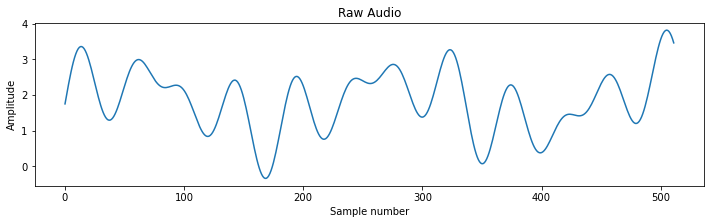

In [6]:
raw =   (numpy.sin((2*numpy.pi*numpy.linspace(0, 511, 512))/45) +
         numpy.sin((2*numpy.pi*numpy.linspace(0, 511, 512))/223)  +
         numpy.sin((2*numpy.pi*numpy.linspace(0, 511, 512))/61) + 2.5)*0.7
plt.plot(raw)
plt.title('Raw Audio')
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.show()

We multiply each raw sample by the corresponding sample in the Hann window:

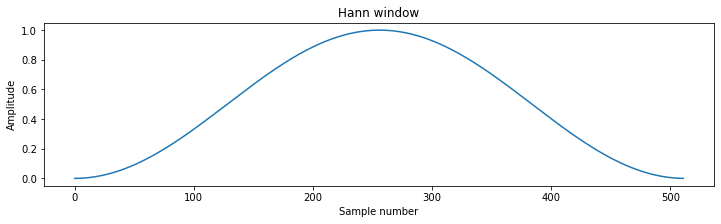

In [7]:
Hann = 0.5*(1-numpy.cos((2*numpy.pi*numpy.linspace(0, 511, 512))/512))
plt.plot(Hann)
plt.title('Hann window');
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.show()

And the result looks like this:

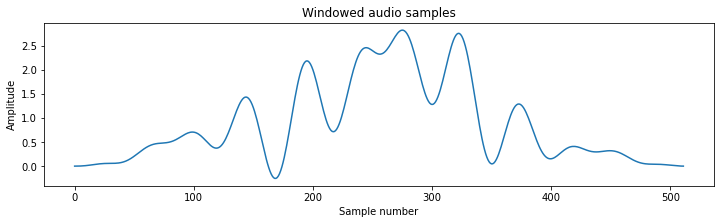

In [8]:
plt.plot(Hann*raw)
plt.title('Windowed audio samples')
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.show()

#### Alpha Max Beta Min Algorithm

The output from the FFT is a collection of complex numbers that have both real parts and imaginary parts. In the spectrogram, we just want to display information related to the *magnitude* of these complex numbers. To compute this value precisely, we would compute the square root of the sum of squares of the real/imaginary parts of each complex number. This, however, is computationally expensive. The [alpha max beta min algorithm](https://en.wikipedia.org/wiki/Alpha_max_plus_beta_min_algorithm) provides a shortcut which is accurate to within about 4% (good enough for us) and is less expensive.

`|amplitude| = max(|Re|, |Im|) + 0.4*min(|Re|, |Im|)`

## Hardware

#### Biased high-pass filter

The audio output voltage is in the range -2V to 2V. We must bias/scale this to the range 0-3.3V for sampling by the ADC. We can do this with a biasing high-pass filter as shown below.

<figure>
    <img align="center" width="400" height="200" src="highpass.png" alt='missing' />
    <center><figcaption>Biased high-pass filter to shift audio input.</figcaption></center>
</figure>

**Note**: If you aren't seeing anything on your spectrogram, check the audio input with the oscilloscope. Make sure the volume isn't turned down.

#### Connections to PIC32

- **Serial**: serial default for protothreads (1.3.2) uses pins: <br>
`PPSInput(2, U2RX, RPA1)`<br>
`PPSOutput(4, RPB10, U2TX)`<br>
*Be sure to uncomment* `#define use_art_serial` *in the config file.*
- **ADC**: <br>
`SetChanADC10( ADC_CH0_NEG_SAMPLEA_NVREF | ADC_CH0_POS_SAMPLEA_AN11 ); // configure to sample AN11 `
- **TFT**: As described on the [Big Board page](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/target_board.html)

## Program organization

Here is a suggestion for how to organize your program:

- **Protothreads** maintains the ISR-driven, millisecond-scale timing as part of the supplied system. Use this for all low-precision timing (can have several milliseconds jitter).
- **ADC ISR** uses a timer interrupt to ensure the exact sample rate that is required for the user-specified frequency range.
> - Gathers an audio sample from the ADC ([fixed-point of some variety](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/index_fixed_point.html), either `_Accum` or something custom, like `fix14`)
> - Scales the sample with a [Hann window](https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows)
> - Stores that scaled sample in an array 512 elements long
> - Signals when the array is full, then waits for a signal to start refilling
- **Main** sets up peripherals and protothreads then just schedules tasks, round-robin
> - Opens interrupt timer and configurs interrupt
> - Opens and configures ADC
> - Initializes TFT display
> - Creates sine wave (needed for `FFTfix` function) and the Hann window array
> - Sets up protothreads and schedules tasks round-robin
- **Python Serial Input Thread [(see here)](https://people.ece.cornell.edu/land/courses/ece4760/PIC32/index_remote.html)**
> - Waits for serial command from Python user interface for a new desired max frequency for the spectrogram (an `int`)
> - If user input is received, disables the interrupt timer, re-draws frequency axis, re-opens interrupt timer to the necessary rate to achieve user's desired max frequency, re-opens the interrupt timer
- **Spectrogram Thread (See example 4 on the [PIC32 DSP Page](https://people.ece.cornell.edu/land/courses/ece4760/PIC32/index_DSP.html) for a place to start)**
> - Waits for signal from ADC ISR that sample array is full
> - Disables interrupts, then copies sample array into a second array (`_Accum fr[]` input in the FFT function above). `_Accum fi[]`, the other input, will be an array of 0's. This is because our samples are real numbers with no imaginary parts.
> - Signals the ISR to start refilling the sample array, then re-enables interrupts
> - Performs FFT by calling `FFTfix` function
> - Computes magnitude of FFT using the [alpha max beta min algorithm](https://en.wikipedia.org/wiki/Alpha_max_plus_beta_min_algorithm). Note that you need only do this for the first half of the real/imaginary output arrays from the FFT since, for purely real-valued signals, the FFT output is perfectly mirrored across the $\frac{N}{2}$ point in the discrete Fourier Transform.
> - Draws spectrogram using the log of computed amplitudes, and prints the frequency with the maximum amplitude

## Weekly checkpoints and lab report

Note that these checkpoints are **cumulative.** In week 2, for example, you must have also completed all of the requirements from week 1.

#### Week one required checkpoint

By the end of lab section in week one you must have:

- Using [this code](https://people.ece.cornell.edu/land/courses/ece4760/PIC32/FFT_TFT_spectrum/TFT_FFT_ADC.c) as a starting point, get a spectrogram displaying on the TFT display that properly redraws itself when it reaches the end of the display (like an oscilloscope). I recommend the colorization scheme given below.
- Test your spectrogram using an online tone generator like [this one](https://www.szynalski.com/tone-generator/)
- Compute and display the maximum frequency
- *Finishing a checkpoint does NOT mean you can leave lab early!*

#### Week two assignment

Timing of all functions in this lab, **and in every exercise in this course** will be handled by interrupt-driven counters, not by software wait-loops. ProtoThreads maintains an ISR driven timer for you. This will be enforced because wait-loops are hard to debug and tend to limit multitasking

*Write a Protothreads C program which will:*

- When the program starts, it begins producing a spectrogram with a range of 0 Hz to 2500 Hz.
- The frequency axis will have axis ticks with labels.
- The maximum frequency will be displayed on the TFT.
- The pixels will be colored according to the *log* of the magnitude of the FFT output. The colorization scheme is up to you, though the spectrograms look nice with black for low magnitude, white for large magnitude, and a gradient of grayscale in between. This are the color choices that I used for the examples on this webpage:<br>
<table align="left | left">
  <tr>
    <th>If Magnitude</th>
    <th>Color</th>
  </tr>
  <tr>
    <td>&#60;1</td>
    <td>0x0000</td>
  </tr>
  <tr>
    <td>&#60;2</td>
    <td>0x2945</td>
  </tr>
  <tr>
    <td>&#60;4</td>
    <td>0x4a49</td>
  </tr>
  <tr>
    <td>&#60;8</td>
    <td>0x738e</td>
  </tr>
  <tr>
    <td>&#60;16</td>
    <td>0x85c1</td>
  </tr>
  <tr>
    <td>&#60;32</td>
    <td>0xad55</td>
  </tr>
  <tr>
    <td>&#60;64</td>
    <td>0xc638</td>
  </tr>
  <tr>
      <td>else</td>
      <td>0xFFFF</td>
</table>
- As you draw each row/column of pixels, you must have a blank region at least 5 pixels wide in front of the row/column that you are drawing (like an oscilloscope).
- When you reach the end of the TFT, start drawing again from the first row/column.
- Through a Python UI, the user may specify a new maximum frequency for the spectrogram (perhaps via a slider, as shown below). The program will automatically change the ADC sample rate and redraw the axis labels.

*Write a Python program which will:*

- Enable the user to select the maximum frequency for the spectrogram (perhaps via slider, as shown below)

<figure>
    <img align="center" width="400" height="200" src="ui.PNG" alt='missing' />
    <center><figcaption>Python interface for spectrogram manipulation.</figcaption></center>
</figure>

*ECE 5730 students*

In addition to the objectives listed above, ECE 5730 students must allow the user to select between the above colorization thresholds (logarithmic) and the below colorization thresholds (linear):<br>
<table align="left | left">
  <tr>
    <th>If Magnitude</th>
    <th>Color</th>
  </tr>
  <tr>
    <td>&#60;1</td>
    <td>0x0000</td>
  </tr>
  <tr>
    <td>&#60;10</td>
    <td>0x2945</td>
  </tr>
  <tr>
    <td>&#60;20</td>
    <td>0x4a49</td>
  </tr>
  <tr>
    <td>&#60;30</td>
    <td>0x738e</td>
  </tr>
  <tr>
    <td>&#60;40</td>
    <td>0x85c1</td>
  </tr>
  <tr>
    <td>&#60;50</td>
    <td>0xad55</td>
  </tr>
  <tr>
    <td>&#60;60</td>
    <td>0xc638</td>
  </tr>
  <tr>
      <td>else</td>
      <td>0xFFFF</td>
</table>
The mechanism by which the user selects these two modes is up to you. You may use a button, a switch, or you may augment the user interface. What is the user interface that you prefer? Why?

You will be asked to demo your program with an online pure tone generator like [this one](https://www.szynalski.com/tone-generator/), and with any other audio of your choice. This might be your own voice, a song, animal calls, or anything else you think is interesting. At no time during the demo can you reset or reprogram the MCU.

#### Lab report

Your written lab report should include the sections mentioned in the [policy page](http://people.ece.cornell.edu/land/courses/ece4760/EE4760_policy.html), and:

- Photos of your spectrogram, showing at least 2 different frequency ranges
- A heavily commented listing of your code

## Example of working system

<iframe width="560" height="315" src="https://www.youtube.com/embed/6yNN2hy6YhI" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

<iframe width="560" height="315" src="https://www.youtube.com/embed/5olmUStNbFg" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>